In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Load the dataset
data = pd.read_csv('cleaned_mbs_total.csv')

# Tokenization and cleaning
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adarsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Adarsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Get PreCovid Data
data_precovid = data[data['covid'] == 'PreCovid']

# Get Post Covid Data
data_postcovid = data[data['covid'] == 'PostCovid']


In [3]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

#Preprocessing 
data_precovid['tokens'] = data_precovid['cleaned_review'].apply(preprocess_text)

# Create a dictionary and a corpus
pre_dictionary = corpora.Dictionary(data_precovid['tokens'])
pre_corpus = [pre_dictionary.doc2bow(text) for text in data_precovid['tokens']]

# LDA model
num_topics = 5  # Adjust the number of topics as needed
pre_lda_model = models.LdaModel(pre_corpus, num_topics=num_topics, id2word=pre_dictionary, passes=15)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(pre_lda_model, pre_corpus, pre_dictionary)
pyLDAvis.display(vis)



C:\Users\Adarsh\AppData\Local\Temp\ipykernel_6688\2252244926.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_precovid['tokens'] = data_precovid['cleaned_review'].apply(preprocess_text)


In [4]:
#Preprocessing 
data_postcovid['tokens'] = data_postcovid['cleaned_review'].apply(preprocess_text)

# Create a dictionary and a corpus
post_dictionary = corpora.Dictionary(data_postcovid['tokens'])
post_corpus = [post_dictionary.doc2bow(text) for text in data_postcovid['tokens']]

# LDA model
num_topics = 5  # Adjust the number of topics as needed
post_lda_model = models.LdaModel(post_corpus, num_topics=num_topics, id2word=post_dictionary, passes=15)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(post_lda_model, post_corpus, post_dictionary)
pyLDAvis.display(vis)


C:\Users\Adarsh\AppData\Local\Temp\ipykernel_6688\335232536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_postcovid['tokens'] = data_postcovid['cleaned_review'].apply(preprocess_text)


C:\Users\Adarsh\AppData\Local\Temp\ipykernel_6688\52131227.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


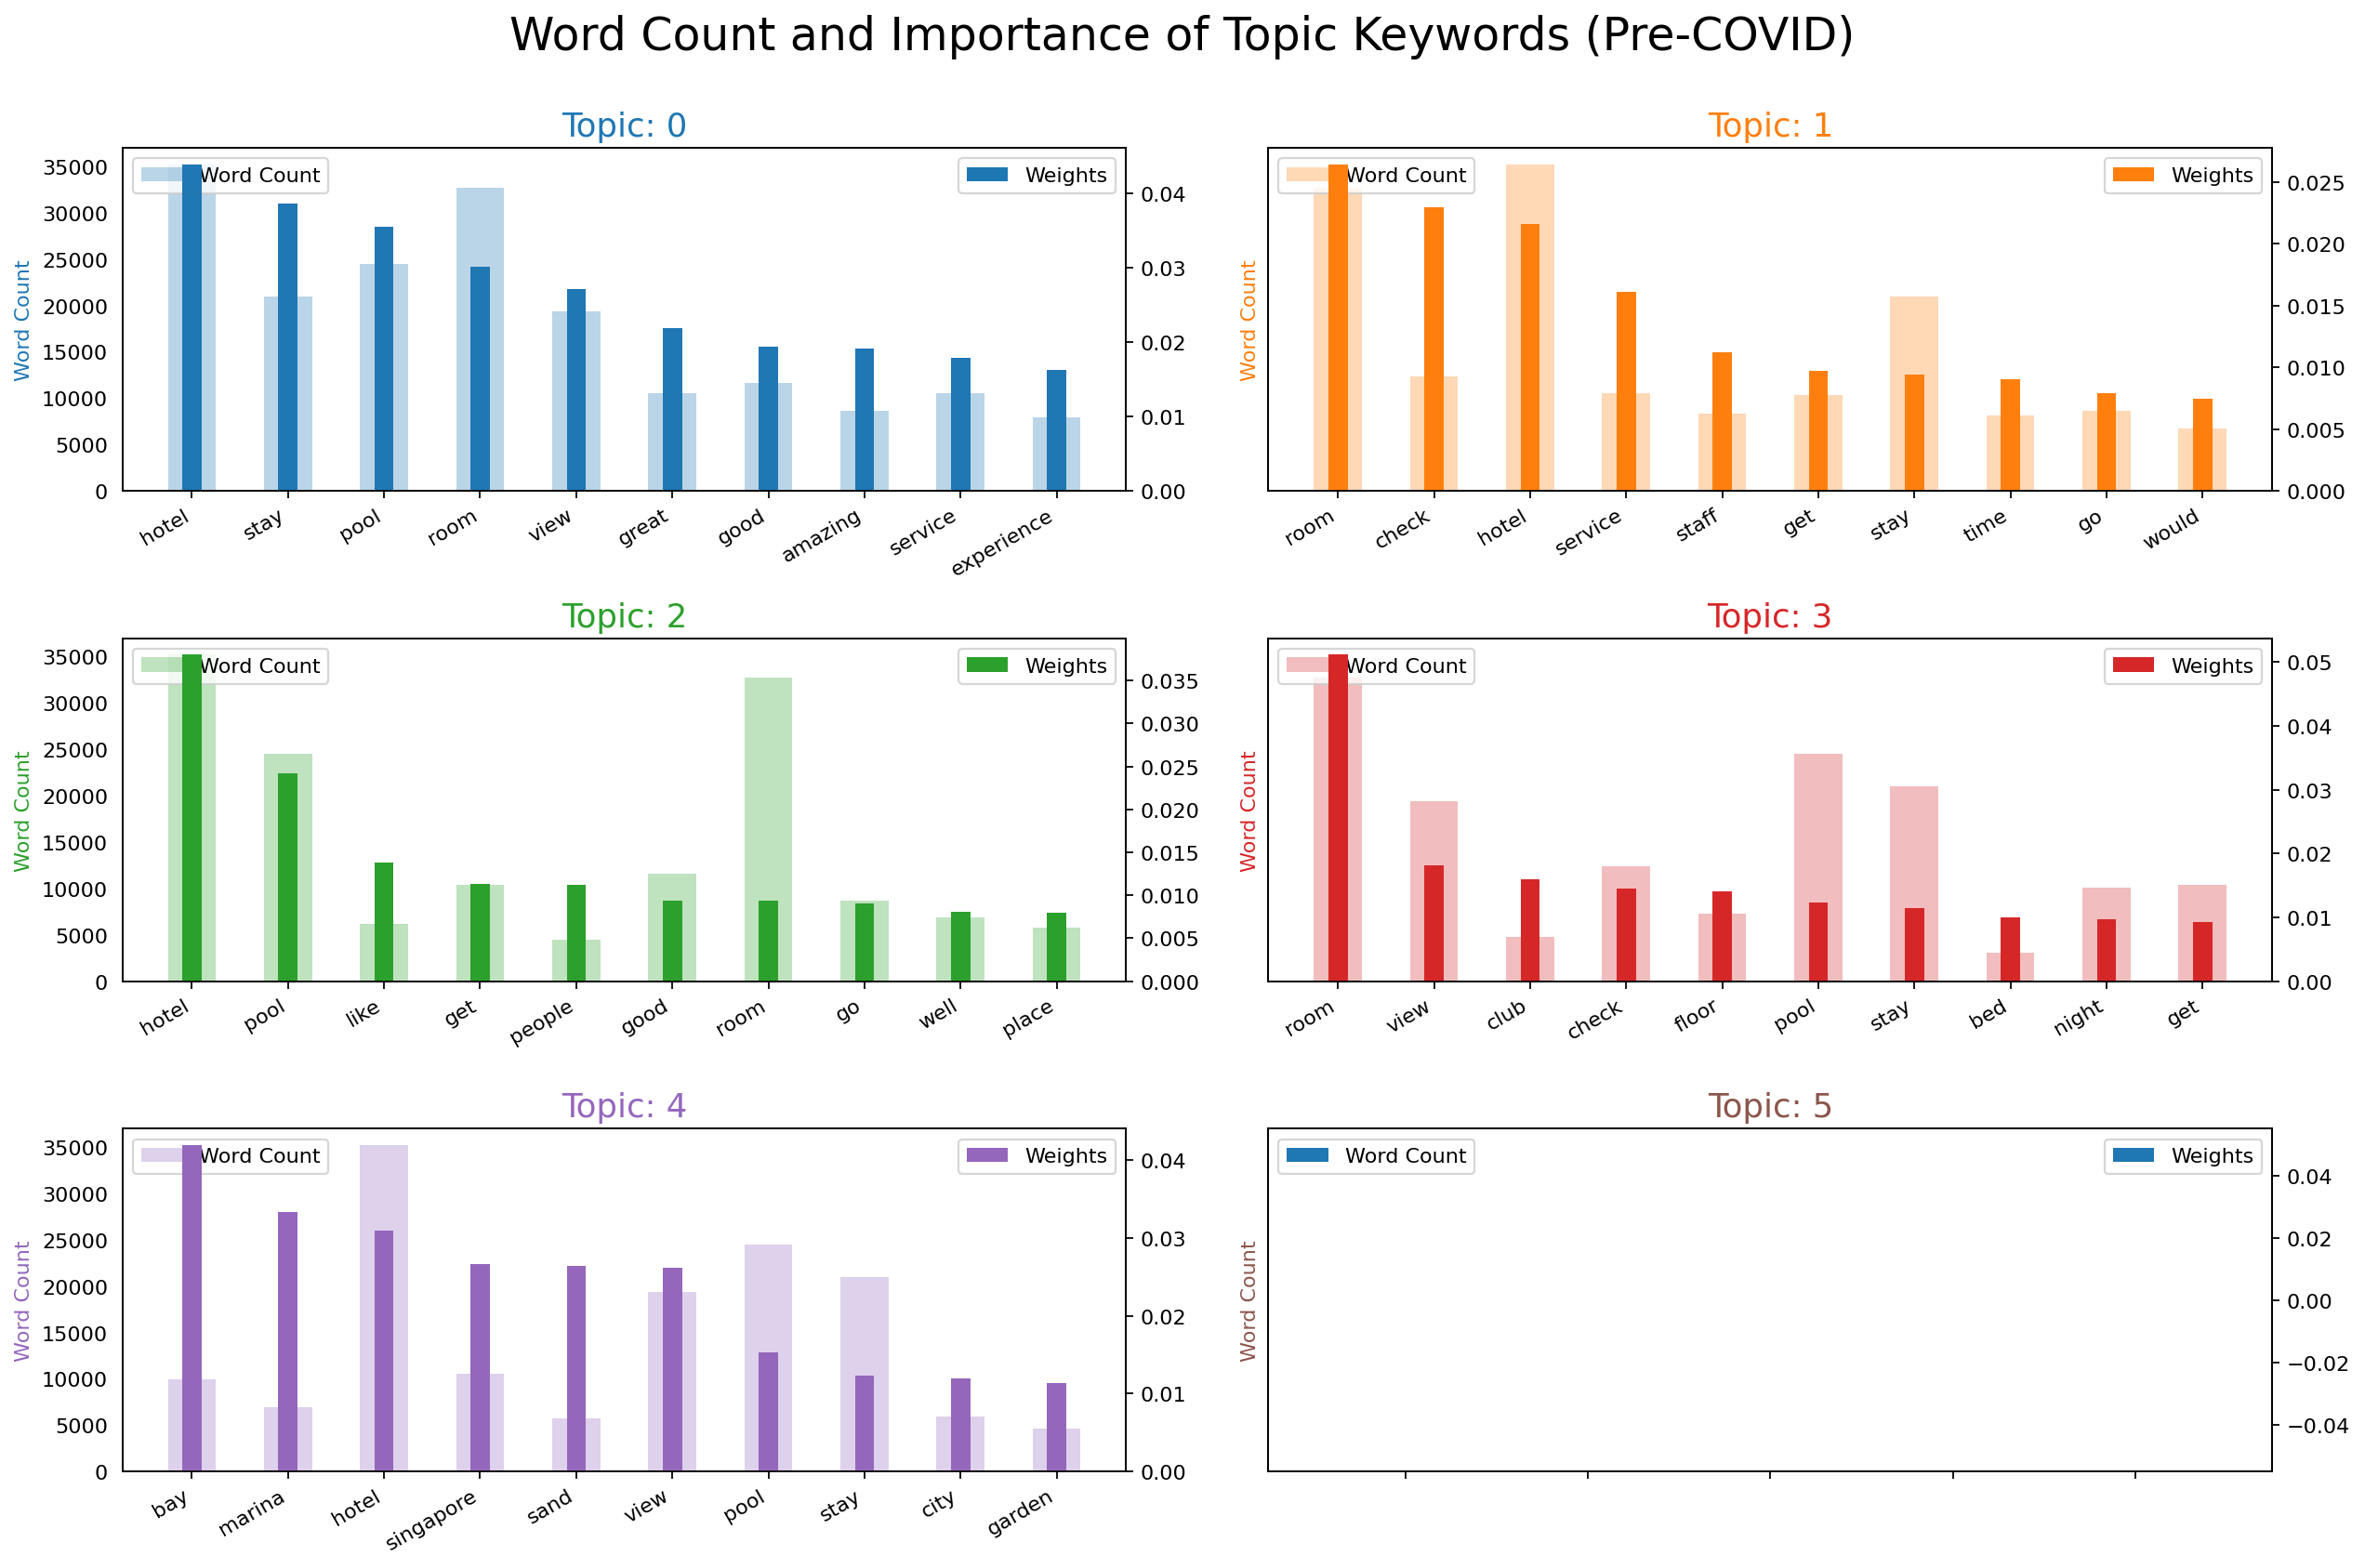

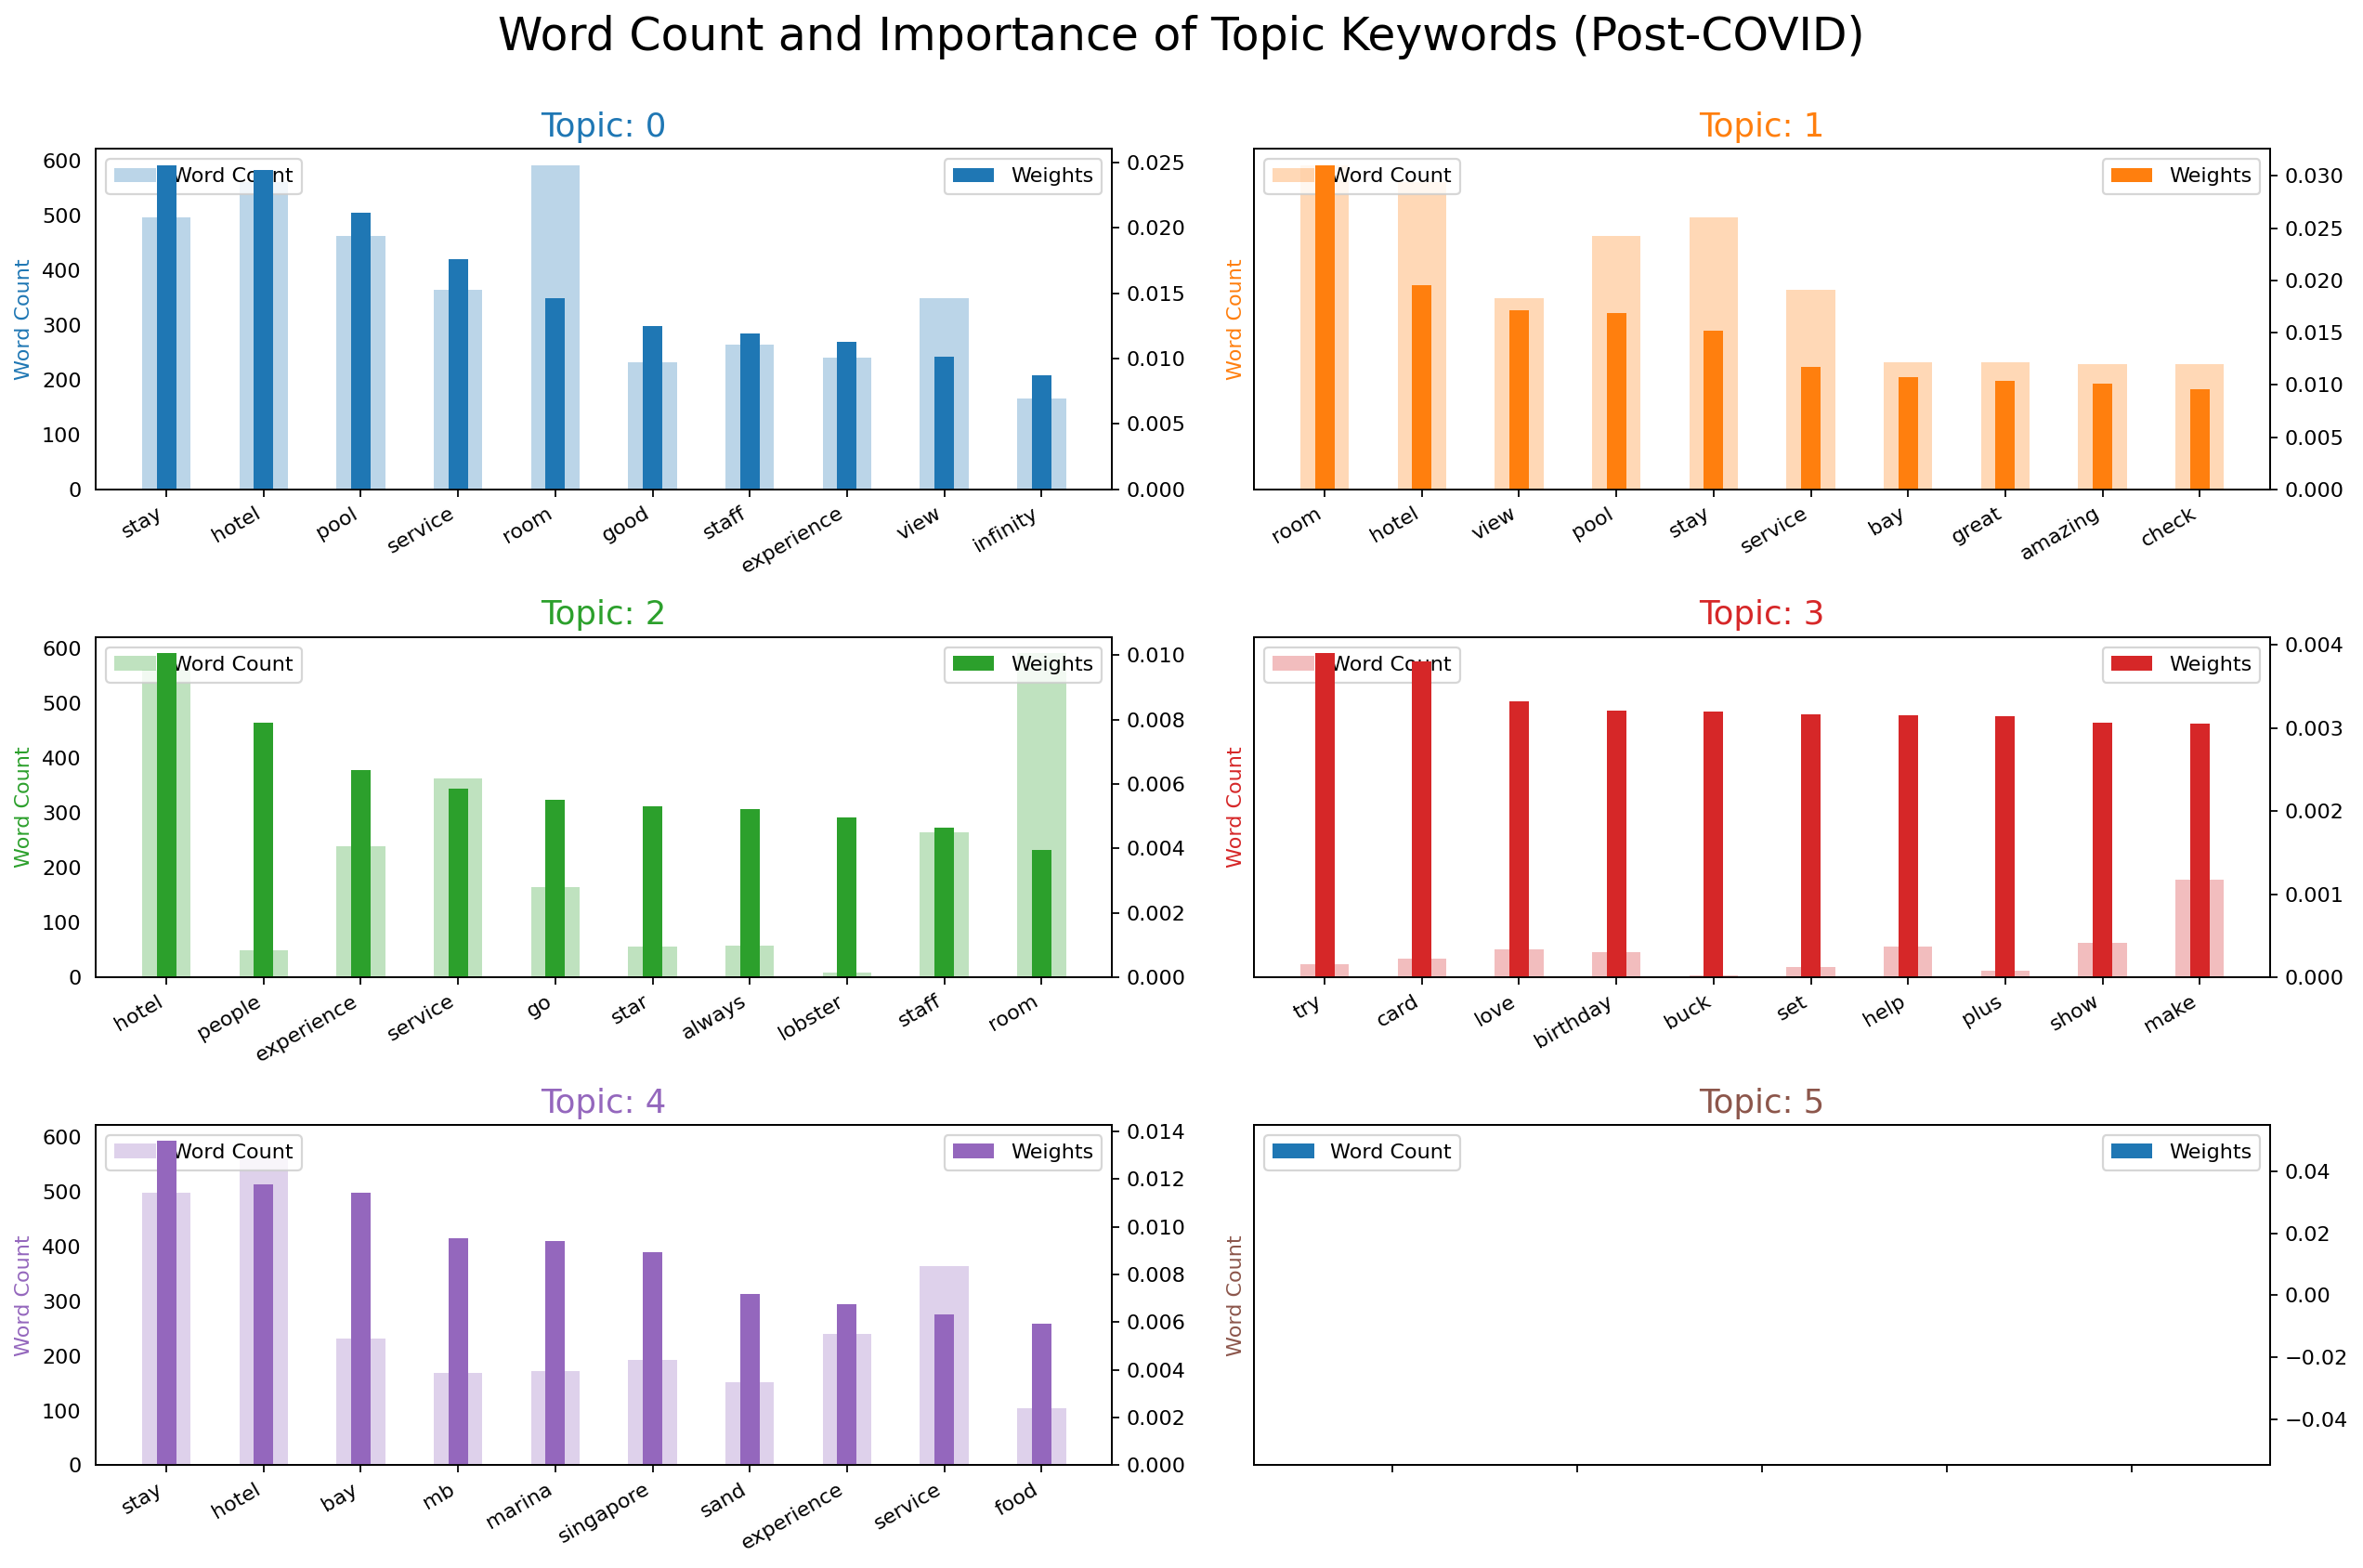

In [9]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


# For Pre-COVID
topics_pre = pre_lda_model.show_topics(formatted=False)
data_flat_pre = [word for word_list in data_precovid['tokens'] for word in word_list]

# For Post-COVID
topics_post = post_lda_model.show_topics(formatted=False)
data_flat_post = [word for word_list in data_postcovid['tokens'] for word in word_list]

# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')


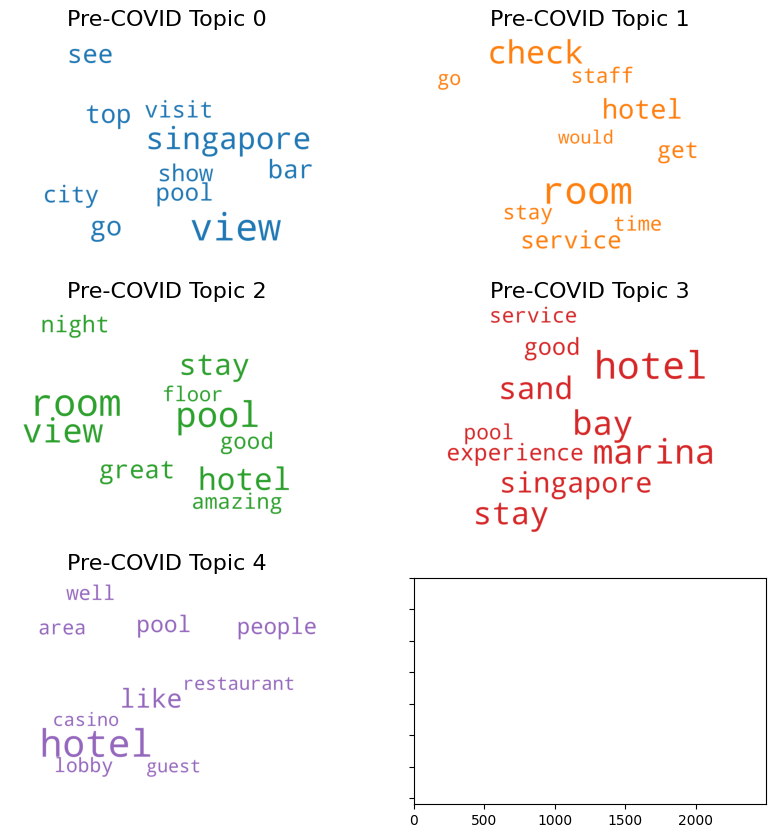

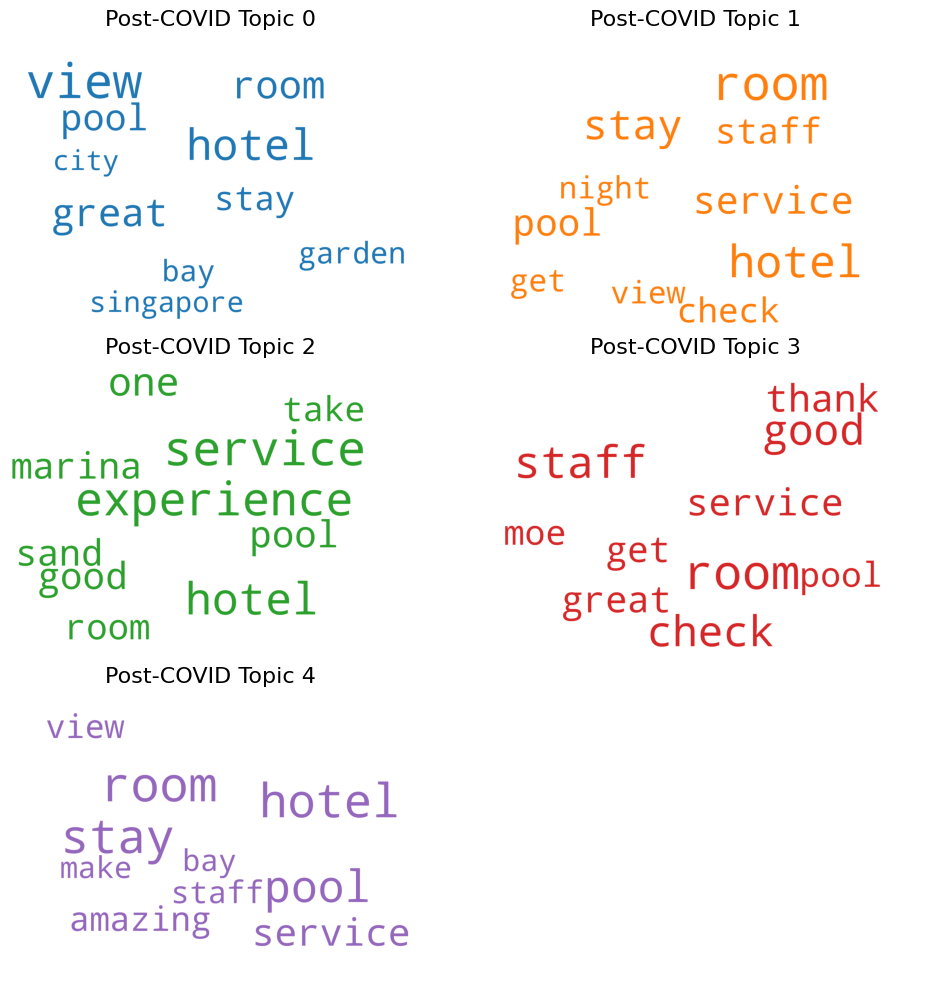

In [23]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(num_topics):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_lda_model.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(num_topics):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_lda_model.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
